<a href="https://colab.research.google.com/github/shahzaib-191/Rhombix-Technologies_Task-1/blob/main/RhombixTechnologies2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required libraries
!pip install yfinance numpy pandas matplotlib scikit-learn tensorflow

# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 1. Fetch and Preprocess Data
# ---------------------------

def load_stock_data(symbol, start_date, end_date):
    """
    Fetches historical stock data for a given symbol using Yahoo Finance.

    Args:
        symbol (str): Stock ticker symbol.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Historical stock data containing the 'Close' prices.
    """
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data[['Close']]

In [4]:
# Set stock ticker, start date, and end date
STOCK_SYMBOL = 'AAPL'  # Apple Inc.
START_DATE = '2015-01-01'
END_DATE = '2024-01-01'

In [6]:
# Fetch stock data
data = load_stock_data(STOCK_SYMBOL, START_DATE, END_DATE)

# Scale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

[*********************100%***********************]  1 of 1 completed


In [7]:
# ---------------------------
# 2. Prepare Training and Test Sets
# ---------------------------

def create_sequences(data, sequence_length):
    """
    Splits data into input sequences and corresponding outputs.

    Args:
        data (np.array): Scaled data.
        sequence_length (int): Number of time steps in each sequence.

    Returns:
        np.array, np.array: Input sequences (X) and outputs (Y).
    """
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length, 0])
        y.append(data[i + sequence_length, 0])
    return np.array(x), np.array(y)


In [8]:
# Define sequence length
SEQUENCE_LENGTH = 60

# Split data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [9]:
# Generate sequences
x_train, y_train = create_sequences(train_data, SEQUENCE_LENGTH)
x_test, y_test = create_sequences(test_data, SEQUENCE_LENGTH)


In [10]:
# Reshape for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
# ---------------------------
# 3. Build and Compile LSTM Model
# ---------------------------

def build_lstm_model(input_shape):
    """
    Builds and compiles an LSTM model.

    Args:
        input_shape (tuple): Shape of the input data.

    Returns:
        keras.Model: Compiled LSTM model.
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [12]:
# Build the model
lstm_model = build_lstm_model((x_train.shape[1], 1))

In [13]:
# ---------------------------
# 4. Train the Model
# ---------------------------

def train_model(model, x_train, y_train, batch_size, epochs):
    """
    Trains the LSTM model.

    Args:
        model (keras.Model): Compiled LSTM model.
        x_train (np.array): Training input sequences.
        y_train (np.array): Training output sequences.
        batch_size (int): Batch size for training.
        epochs (int): Number of training epochs.

    Returns:
        keras.History: Training history object.
    """
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)
    return history

# Train the model
BATCH_SIZE = 32
EPOCHS = 10
train_model(lstm_model, x_train, y_train, BATCH_SIZE, EPOCHS)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0428
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0018
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0012
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0010
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0011
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0010
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 9.3413e-04
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 8.1476e-04


In [14]:
# ---------------------------
# 5. Make Predictions
# ---------------------------

def predict_and_unscale(model, x_test, scaler):
    """
    Makes predictions and reverses scaling on predictions.

    Args:
        model (keras.Model): Trained LSTM model.
        x_test (np.array): Test input sequences.
        scaler (MinMaxScaler): Scaler used for data preprocessing.

    Returns:
        np.array: Unscaled predictions.
    """
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

# Make predictions
predictions = predict_and_unscale(lstm_model, x_test, scaler)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


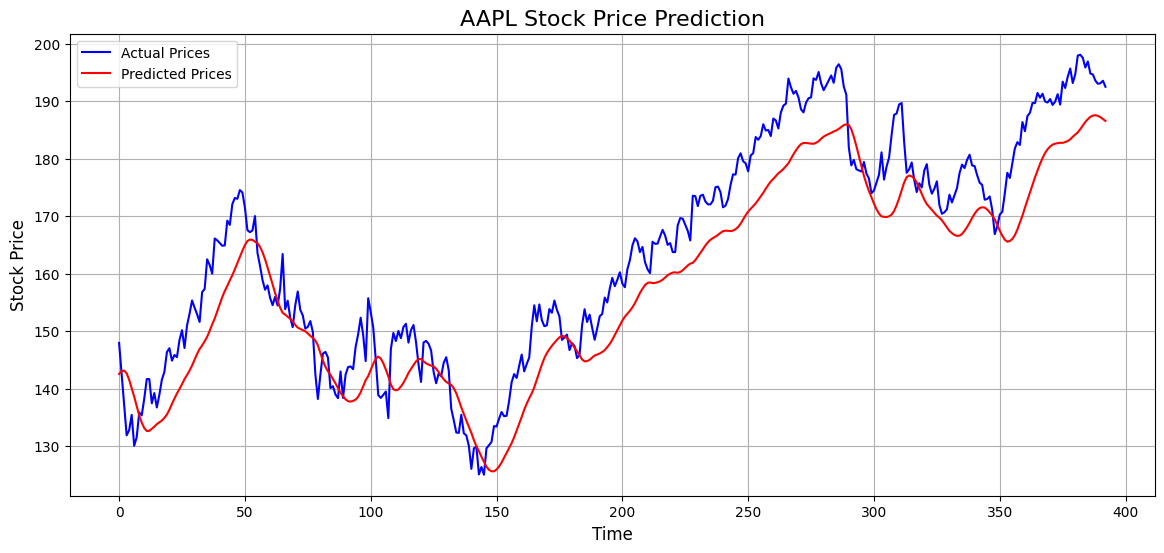

In [15]:
# ---------------------------
# 6. Visualize Results
# ---------------------------

def plot_predictions(actual, predicted, title):
    """
    Plots actual vs predicted stock prices.

    Args:
        actual (np.array): Actual stock prices.
        predicted (np.array): Predicted stock prices.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(actual, label='Actual Prices', color='blue')
    plt.plot(predicted, label='Predicted Prices', color='red')
    plt.title(title, fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

# Visualize predictions
plot_predictions(actual_prices, predictions, f'{STOCK_SYMBOL} Stock Price Prediction')